In [1]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
import json
import csv
import time

def write_to_file(stuff):
    csvFile = open(r'io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

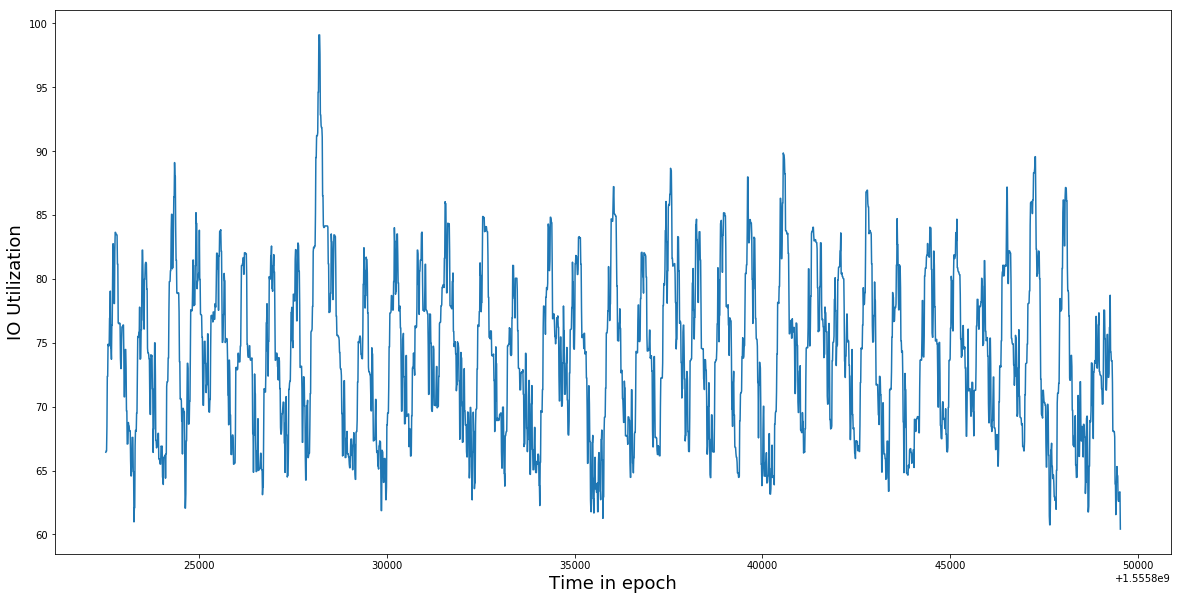

In [2]:
dataframe1 = pd.read_csv('io-util.csv')
x1 = dataframe1['TIME'].tolist()
y1 = dataframe1['UTIL'].tolist()

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [3]:
split_percent = 0.8448
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

420
2281


In [4]:
def wma(Y_Train, law=6):
    Y_Train = Y_Train[-60:]
    prediction = []

    for i in range(law):
        weights = np.arange(1, len(Y_Train) + 1)
        prediction.append(np.sum(Y_Train*weights)/sum(weights))
        Y_Train = np.append(Y_Train, [prediction])
        return prediction

In [5]:
X_Test = []
Y_Test = []
Predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[0 : train_samples + i]
    X_Train = x1[0 : train_samples + i]
    
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])
    Predictions.append(wma(Y_Train)[-1])

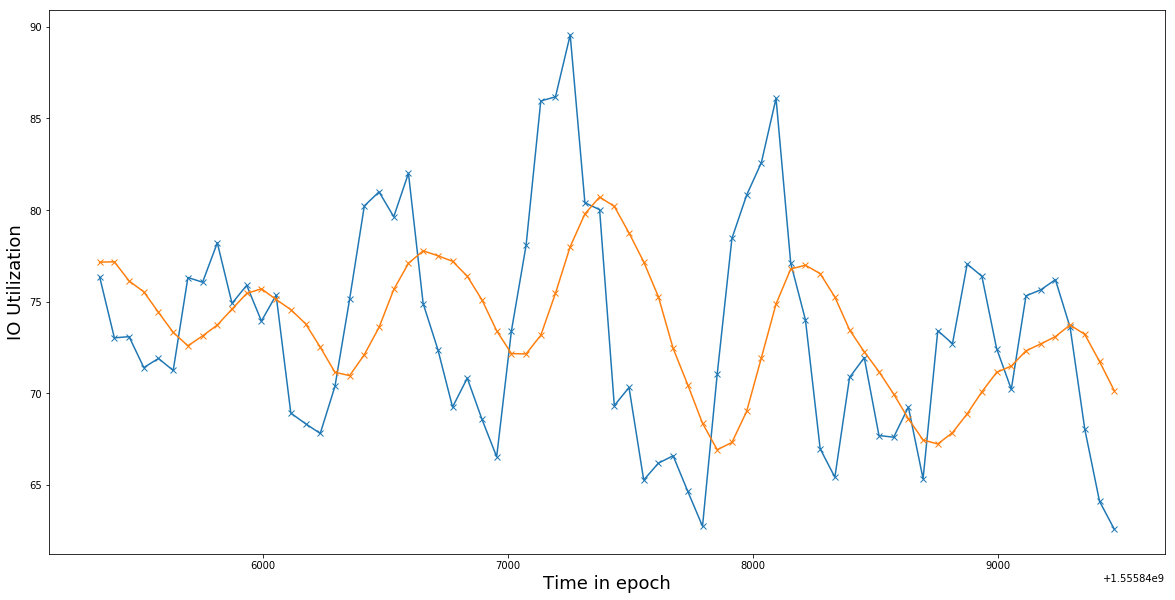

In [6]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Predictions, {'marker': 'x'})

In [7]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
Predictions

[77.15652557889514,
 77.1772819432872,
 76.13080793666975,
 75.5373945064178,
 74.41816232581424,
 73.32403224472175,
 72.59252971611703,
 73.13404185532939,
 73.72609915711071,
 74.59641834866959,
 75.4497182707433,
 75.70419391901773,
 75.1204435103465,
 74.56531262582685,
 73.79787863100374,
 72.51881967213114,
 71.15023065861375,
 70.96405867126833,
 72.11282369859073,
 73.59644060972103,
 75.66491573195282,
 77.09092205924647,
 77.7746241012367,
 77.50675409836066,
 77.20390451538681,
 76.38854184641933,
 75.09687431693989,
 73.41242910555077,
 72.1680092033362,
 72.14916767328155,
 73.16670300014395,
 75.4589245488855,
 78.00148834669233,
 79.78974900961273,
 80.7094494194414,
 80.20065771862916,
 78.74989305931771,
 77.17321103705946,
 75.26622480952214,
 72.45386249695102,
 70.45616787900221,
 68.36431634611097,
 66.92253597195322,
 67.31928973806603,
 69.0139114743772,
 71.9307274633261,
 74.87632947414073,
 76.78547557907434,
 76.98911594019812,
 76.5312886069237,
 75.2575257

In [9]:
mean_absolute_percentage_error(Y_Test, Predictions)

6.874775789732084

# CPU

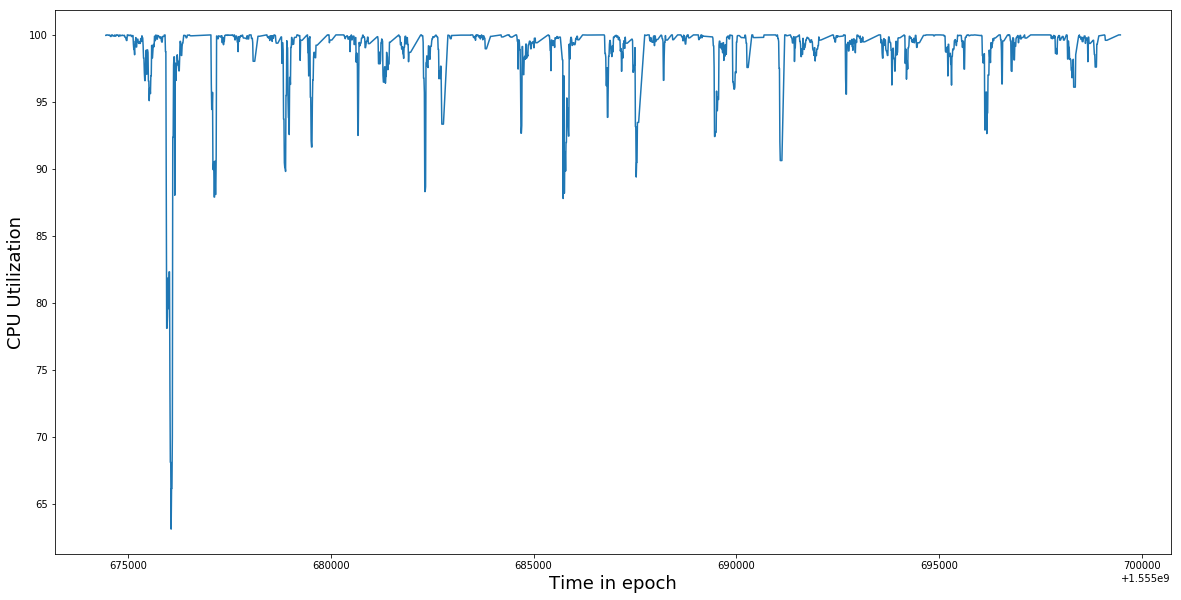

In [10]:
dataframe1 = pd.read_csv('cpu-util-new.csv')
x1 = dataframe1['TIME'].tolist()
y1 = dataframe1['UTIL'].tolist()

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [11]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

347
1385


In [12]:
X_Test = []
Y_Test = []
Predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[0 : train_samples + i]
    X_Train = x1[0 : train_samples + i]
    
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])
    Predictions.append(wma(Y_Train)[-1])

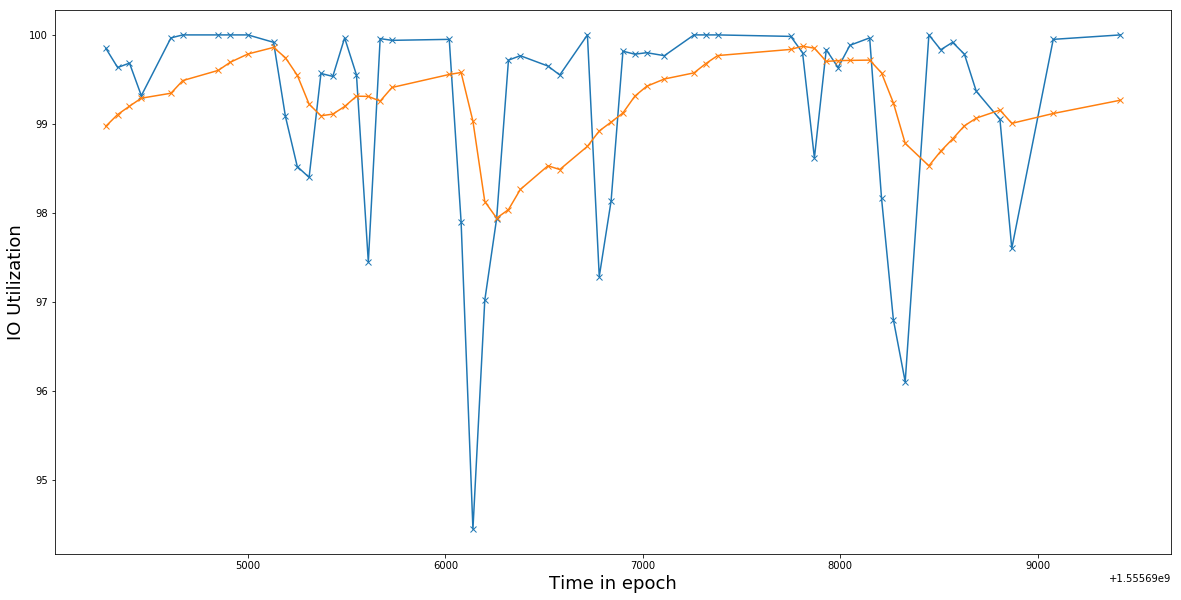

In [13]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Predictions, {'marker': 'x'})

In [14]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
mean_absolute_percentage_error(Y_Test, Predictions)

0.8368570069930722

In [16]:
Predictions

[98.97273622410326,
 99.10498112165956,
 99.19869946942538,
 99.28861414774154,
 99.34433344141667,
 99.4866836606909,
 99.60136949954449,
 99.69192237822021,
 99.78542808457736,
 99.85943633153089,
 99.74350709920499,
 99.54690627396607,
 99.22123523216924,
 99.09074481942176,
 99.1095841336977,
 99.19535543960751,
 99.31116894064388,
 99.30871730699388,
 99.25569687124869,
 99.40909228909035,
 99.55525343886812,
 99.57746405999748,
 99.0298348834757,
 98.126864727951,
 97.94064151838481,
 98.03556885950124,
 98.2623662736634,
 98.52849115708572,
 98.48679255031584,
 98.74723382956127,
 98.92022304699248,
 99.01962822612964,
 99.12249590466514,
 99.31088471563916,
 99.42228263999979,
 99.50449802783423,
 99.5731974655874,
 99.67786664092073,
 99.76786275398054,
 99.83689283478354,
 99.87302599491227,
 99.85085270872638,
 99.70270083008486,
 99.71045323851337,
 99.71351999433224,
 99.71674476420262,
 99.57279290364313,
 99.23635432169566,
 98.780708089475,
 98.52819786211161,
 98.69267

# Memory

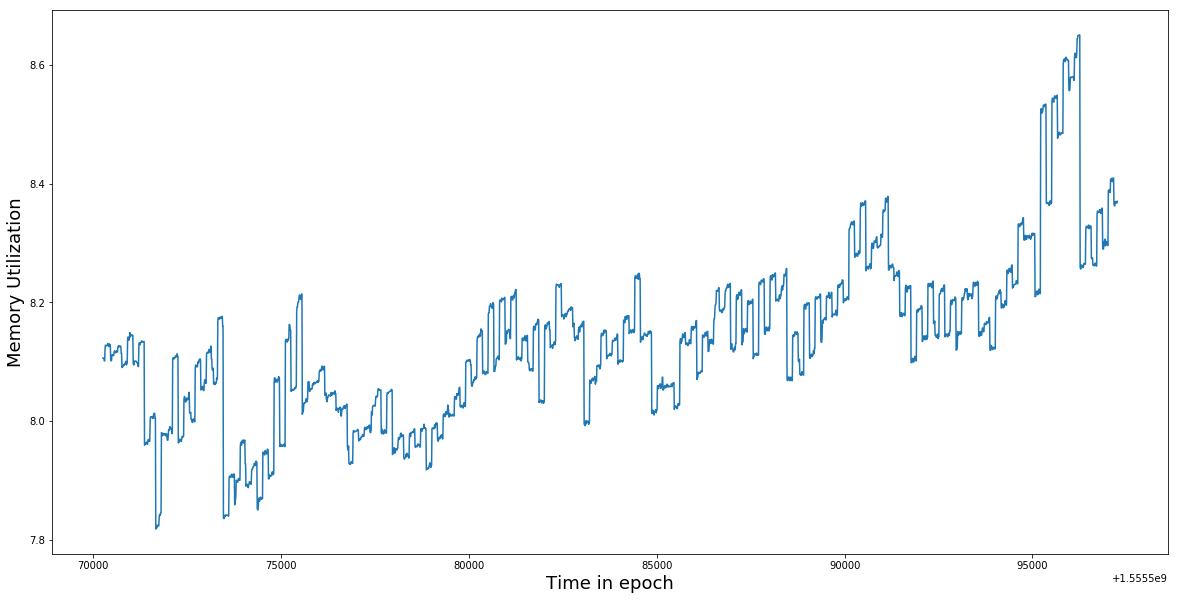

In [17]:
dataframe1 = pd.read_csv('mem-util.csv')
x1 = dataframe1['TIME'].tolist()
y1 = dataframe1['UTIL'].tolist()

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('Memory Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [18]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

541
2160


In [19]:
X_Test = []
Y_Test = []
Predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[0 : train_samples + i]
    X_Train = x1[0 : train_samples + i]
    
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])
    Predictions.append(wma(Y_Train)[-1])

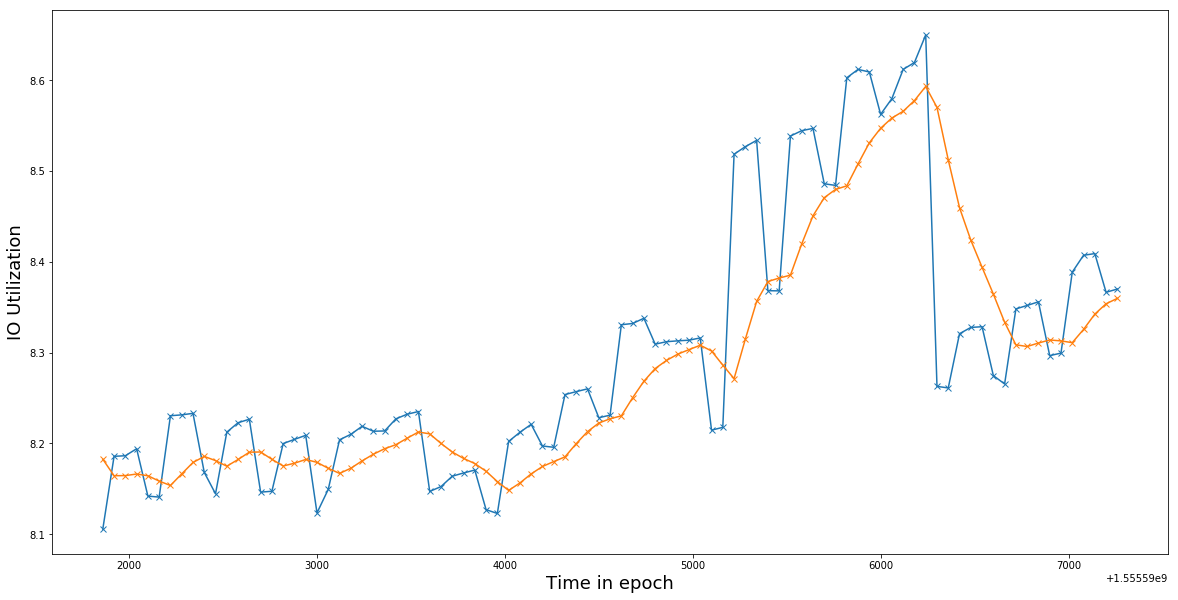

In [20]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Predictions, {'marker': 'x'})

In [21]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mean_absolute_percentage_error(Y_Test, Predictions)

0.6714098610846055

In [23]:
Predictions

[8.182629025661996,
 8.164458609547914,
 8.164626065758036,
 8.166337717619847,
 8.16443715684103,
 8.158565409900824,
 8.153727797882325,
 8.166494088156991,
 8.179051826713563,
 8.185730512166103,
 8.181114387368861,
 8.174949848242461,
 8.182339839979255,
 8.190421867826876,
 8.190602871714173,
 8.182563230263217,
 8.175194158908072,
 8.178237462264228,
 8.182365710985572,
 8.17921128473706,
 8.172662686263296,
 8.167032149194217,
 8.172672787134587,
 8.180807634953439,
 8.188125243766697,
 8.194209548172378,
 8.198649393468765,
 8.205788353933881,
 8.212616582852458,
 8.210552292140152,
 8.200017602398471,
 8.190586901957188,
 8.183538303700345,
 8.177871661672352,
 8.169401635270644,
 8.158044250189741,
 8.148300090035095,
 8.156474449694354,
 8.166494806796058,
 8.174650069287587,
 8.18002075179425,
 8.185212972266605,
 8.19981421423514,
 8.21304044681911,
 8.22244865651931,
 8.227175571505635,
 8.23035954180457,
 8.250311237920918,
 8.26848209320332,
 8.282448470791033,
 8.29133